___

# Machine Learning in Geosciences 
Department of Applied Geoinformatics and Carthography, Charles University

Lukas Brodsky lukas.brodsky@natur.cuni.cz

### Notes from the lecture:
ExtraTrees - see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
- while both methods construct ensembles of decision trees using random feature selection, Random Forests rely on bootstrap sampling and optimal split search at each node, whereas ExtraTrees forego bootstrapping and introduce additional randomness by selecting random split points. This trade-off usually means that ExtraTrees are faster to train and may offer lower variance at the expense of a slight increase in bias.

## Exercise: Building and Evaluating Ensemble Models

This notebook is dedicated to ensemble learning exercizes. 

**Objective**:
Understand and implement different ensemble learning techniques — Bagging, Boosting, and Stacking and compare their performance.

Tasks: 
1. Implement Bagging using `BaggingClassifier()` and compare the result with a weak classifier, e.g. `DecisionTreeClassifier()` using high variance (noisy moons) dataset. 

2. Implement Boosting using `GradientBoostingClassifier()` and compare result with a weak classifier `DecisionTreeClassifier()` on  a complex decision boundary (circles) dataset. 

3. Implement Stacking using `StackingClassifier()` based on `SVC()`, `DecisionTreeClassifier()` and `KNeighborsClassifier()` and `LogisticRegression()`. Compare the stacking result with single weak classifiers, e.g. `DecisionTreeClassifier()`.  

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# ensmbles 
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier
# base estimators 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report

### Dataset 1 - bagging

In [2]:
# Dataset 1 for BAGGING: High Variance (Noisy Moons)
X_bagging, y_bagging = make_moons(n_samples=1000, noise=0.4, random_state=42)
X_train_bag, X_test_bag, y_train_bag, y_test_bag = train_test_split(X_bagging, y_bagging, 
                                                                    test_size=0.2, random_state=42)

Text(0.5, 1.0, 'Dataset: High Variance')

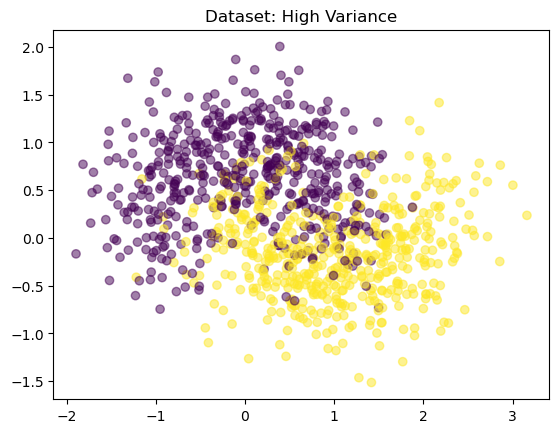

In [3]:
plt.scatter(X_bagging[:, 0], X_bagging[:, 1], c=y_bagging, cmap="viridis", alpha=0.5)
plt.title("Dataset: High Variance")

### Bagging classifier

**A Bagging classifier** is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

`
class sklearn.ensemble.BaggingClassifier(
    estimator=None, 
    n_estimators=10, 
    max_samples=1.0,
    max_features=1.0, 
    bootstrap=True,
    n_jobs=None
    )
`

In [5]:
# hyperparameters tunes number of estimators, sample size, and bootstrap settings.
bagging_params = {
    "n_estimators": [50, 100, 150, 200],
    "max_samples": [0.5, 0.8, 1.0]
}


In [10]:
# use GridSearchCV() on BaggingClassifier() with DecisionTreeClassifier()
# cv=10, return_train_score=True 
bagging_grid = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=42), bootstrap=True),
                            bagging_params, n_jobs=-1)

In [11]:
# search and fit 
estimator = bagging_grid.fit(X_train_bag, y_train_bag)

In [14]:
# best paramters are: estimator.best_params_
print("Best Parameters: ", estimator.best_params_)

Best Parameters:  {'max_samples': 0.5, 'n_estimators': 100}


In [15]:
# the best one is: estimator.best_estimator_
print("Best Estimator: ", estimator.best_estimator_)

Best Estimator:  BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=0.5, n_estimators=100)


#### Model evaluation

In [17]:
# training score: estimator.best_score_
BC_train_acc = estimator.best_score_
print("Training Accuracy: ", round(BC_train_acc, 3))

Training Accuracy:  0.855


In [18]:
# prediction for testing 
bagging_pred = estimator.predict(X_test_bag) 

In [20]:
# accuracy: accuracy_score(y_test_bag, bagging_pred)
BC_test_acc = accuracy_score(y_test_bag, bagging_pred)
print("Testing Accuracy: ", round(BC_test_acc, 3))

Testing Accuracy:  0.85


In [21]:
# classification report
print(classification_report(y_test_bag, bagging_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       100
           1       0.86      0.83      0.85       100

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



#### Plot decision boundary

In [22]:
# Ensemble Decision Boundary
def plot_ensmble_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    for model in model.estimators_:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, alpha=0.1)

    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", marker="o", alpha=0.3)
    plt.title(title)

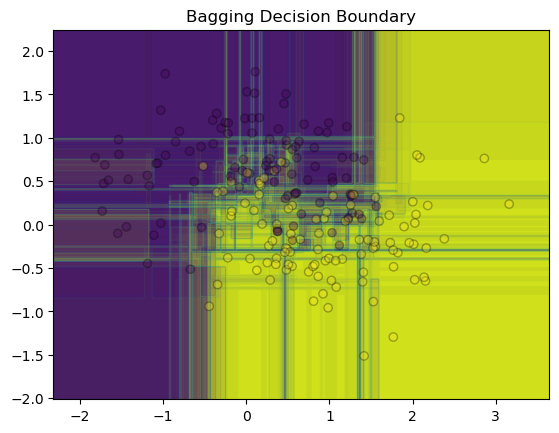

In [24]:
plot_ensmble_boundary(estimator.best_estimator_, X_test_bag, y_test_bag, "Bagging Decision Boundary")

### Single model Decision Tree

In [25]:
# DT DecisionTreeClassifier()  
singleDT = DecisionTreeClassifier(random_state=42)

In [26]:
# fit the model 
singleDT.fit(X_train_bag, y_train_bag)

DecisionTreeClassifier(random_state=42)

In [30]:
# training accuracy: accuracy_score()
DT_train_acc = accuracy_score(y_train_bag, singleDT.predict(X_train_bag)) 
DT_train_acc

1.0

In [31]:
# testing accuracy: accuracy_score()
DT_test_acc = accuracy_score(y_test_bag, singleDT.predict(X_test_bag))

In [ ]:
# Decision Boundary Plot
def plot_decision_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", marker="o", alpha=0.3)
    plt.contourf(xx, yy, Z, alpha=0.5)

    plt.title(title)
    

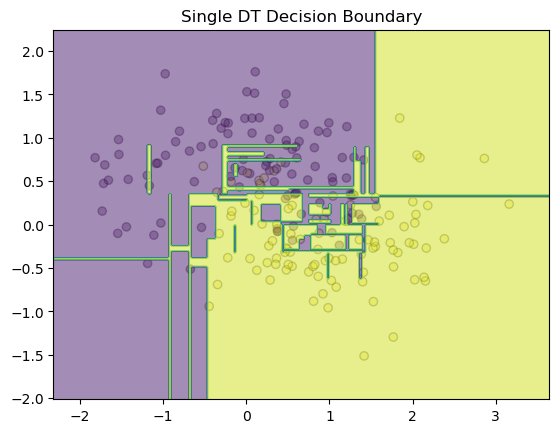

In [33]:
plot_decision_boundary(singleDT, X_test_bag, y_test_bag, "Single DT Decision Boundary")

#### Models comparison (accuarcy)

In [34]:
print("\n===== Models Comparision =====")
print(f'Bagging training error: {round(BC_train_acc, 2)}')
print(f'Bagging testing  error: {round(BC_test_acc , 2)}')
print('---')
print(f'Decition Tree training: {round(DT_train_acc, 2)}')
print(f'Decition Tree training: {round(DT_test_acc, 2)}')


===== Models Comparision =====
Bagging training error: 0.85
Bagging testing  error: 0.85
---
Decition Tree training: 1.0
Decition Tree training: 0.78


### Does averaging weak learners reduces overfitting on noisy data? 

.

### Boosting classifier 

**Gradient Boosting** for classification builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. 

`
class sklearn.ensemble.GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3
    )
`

where learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. Values must be in the range [0.0, inf).

### Dataset 2 - boosting 

In [35]:
# Dataset 2 for BOOSTING: Complex Decision Boundary (Circles)
X_boosting, y_boosting = make_circles(n_samples=1000, noise=0.2, factor=0.5, random_state=42)
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(X_boosting, y_boosting, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'Dataset: Complex Decision Boundary')

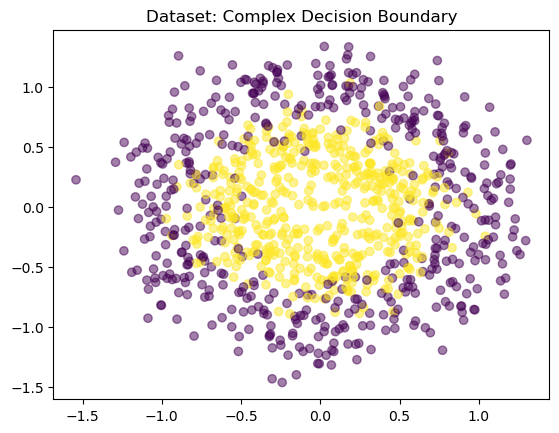

In [36]:
plt.scatter(X_boosting[:, 0], X_boosting[:, 1], c=y_boosting, cmap="viridis", alpha=0.5)
plt.title("Dataset: Complex Decision Boundary")

### Boosting classifier

In [37]:
# Boosting model
boosting_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [38]:
# Boosting: optimizes tree depth, learning rate, and number of estimators
boosting_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [2, 3, 4]
}

In [57]:
# run GridSearchCV() on GradientBoostingClassifier 
# cv=5
boosting_grid = GridSearchCV(GradientBoostingClassifier(random_state=42),
                             boosting_params, n_jobs=-1, cv=5)

In [58]:
# fit through grid search CV 
estimator = boosting_grid.fit(X_train_boost, y_train_boost) 

In [60]:
# the best one: boosting_estimator.best_estimator_
print("Best Estimator: ", estimator.best_estimator_)
print(f'Best parameters: {estimator.best_params_} ')

Best Estimator:  GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=200,
                           random_state=42)
Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200} 


In [61]:
# training score: boosting_estimator.best_score_
Boost_train_acc = estimator.best_score_
print("Training Accuracy: ", round(Boost_train_acc, 3))

Training Accuracy:  0.894


In [64]:
# test the model 
boosting_pred = estimator.predict(X_test_bag)


In [65]:
# testing acccuracy accuracy_score()
boost_test_acc = accuracy_score(y_test_boost, boosting_pred)

In [67]:
# print
print(f'Boosting testing accuracy: {round(boost_test_acc, 3)}')

Boosting testing accuracy: 0.57


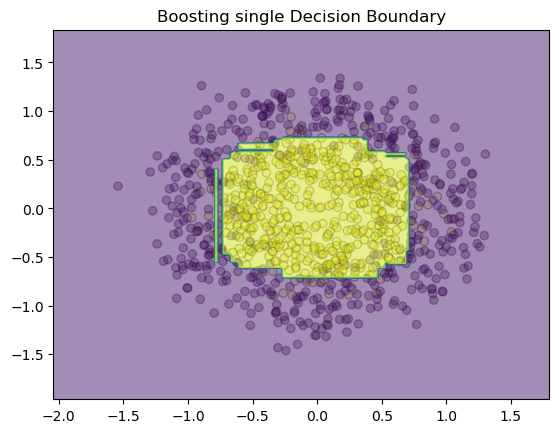

In [68]:
plot_decision_boundary(estimator.best_estimator_, X_boosting, y_boosting, "Boosting single Decision Boundary")

In [69]:
# Function to Plot Decision Boundaries at Different Stages
def plot_decision_boundaries_ensemble(model, X, y, stages=[1, 5, 50, 100], 
                                      title="Gradient Boosting Evolution"):
    h = 0.02  # Step size in meshgrid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    fig, axes = plt.subplots(1, len(stages), figsize=(15, 4))
    for ax, stage in zip(axes, stages):
        # Partial predictions using first `stage` trees
        stage_model = GradientBoostingClassifier(n_estimators=stage, learning_rate=0.1, random_state=42)
        stage_model.fit(X, y)
        Z = stage_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot decision boundary
        ax.contourf(xx, yy, Z, alpha=0.5)
        ax.set_title(f"{stage} Model(s)")
        ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", marker="o", alpha=0.1)
    plt.suptitle(title)
    plt.show()

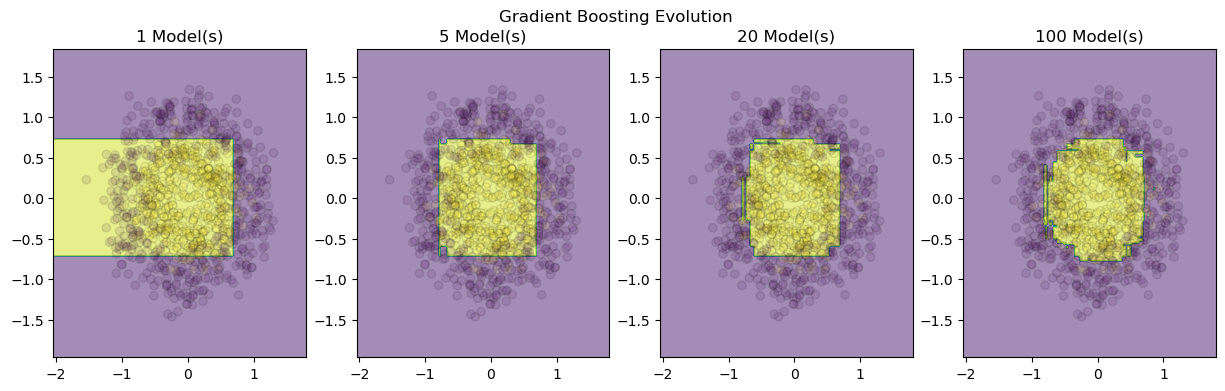

In [71]:
plot_decision_boundaries_ensemble(estimator.best_estimator_, X_boosting, y_boosting, stages=[1, 5, 20, 100], 
                                  title="Gradient Boosting Evolution")

### Weaker classifier

In [76]:
dt = DecisionTreeClassifier(random_state=42)
dt2 = DecisionTreeClassifier(random_state=42, max_depth=2)


In [77]:
dt.fit(X_train_boost, y_train_boost)
dt2.fit(X_train_boost, y_train_boost)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [78]:
# training accuracy
DT_train_acc = accuracy_score(y_train_boost, dt.predict(X_train_boost)) 
DT2_train_acc = accuracy_score(y_train_boost, dt2.predict(X_train_boost))

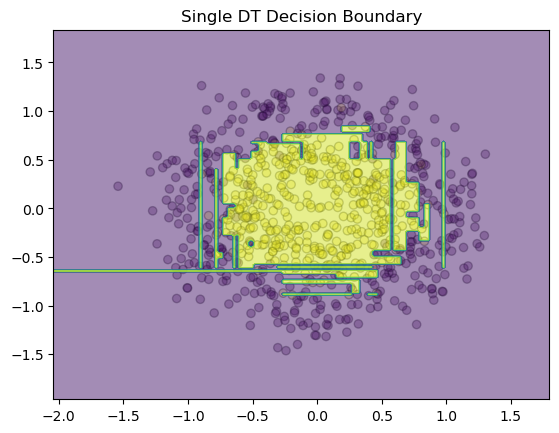

In [ ]:
plot_decision_boundary(dt, X_train_boost, y_train_boost, "Single DT Decision Boundary")
plot_decision_boundaries_ensemble(dt, X_train_boost, y_train_boost, stages=[1, 5, 20, 100],
                                  title="Single Decision Tree Evolution")


In [79]:
print("\n===== Models Comparision =====")
print(f'Boosting training error: {round(Boost_train_acc, 2)}')
print(f'Boosting testing  error: {round(boost_test_acc, 2)}')
print('---')
print(f'Decition Tree training: {round(DT_train_acc, 2)}')
print(f'Decition Tree testing: {round(DT_test_acc, 2)}')


===== Models Comparision =====
Boosting training error: 0.89
Boosting testing  error: 0.57
---
Decition Tree training: 1.0
Decition Tree testing: 0.78


### Does boosting improves weak model errors in overlapping, complex patterns? 

.

### Stacking 

**Stack of estimators with a final classifier** consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

`
class sklearn.ensemble.StackingClassifier(
    estimators,
    final_estimator
    )
`

wehere `estimators` are base estimators, 
and `final_estimator` is a classifier which will be used to combine the base estimators. The default classifier is a LogisticRegression.

### Dataset 3 - stacking

In [80]:
# Dataset 3 for STACKING: Diverse Model Mistakes (Classification)
X_stacking, y_stacking = make_classification(n_samples=1000, n_features=10, n_informative=3, class_sep=0.5, 
                                             n_redundant=2, n_clusters_per_class=2, random_state=42)

X_train_stack, X_test_stack, y_train_stack, y_test_stack = train_test_split(X_stacking, y_stacking, 
                                                                            test_size=0.2, random_state=42)

In [81]:
# use SVM, DT, and KNN 
stacking_estimators = [
    ('svm', SVC(probability=True, kernel='rbf', random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

In [82]:
# stacking: fine-tunes Logistic Regression used as the meta-classifier. 
stacking_params = {
    "final_estimator__C": [0.1, 1, 10]  # regularization strength for Logistic Regression
}

In [87]:
# run GridSearchCV() on StackingClassifier() using e.g. cv=10 
stacking_grid = GridSearchCV(StackingClassifier(estimators=stacking_estimators, final_estimator=LogisticRegression(), n_jobs=-1), param_grid=stacking_params, cv=10)

In [88]:
# fit the model
estimator = stacking_grid.fit(X_train_stack, y_train_stack)

In [90]:
# the best one is: .best_estimator_
best_estimator = estimator.best_estimator_

In [92]:
# training score: .best_score_
Stack_train_acc = estimator.best_score_

In [93]:
# testing: 
stacking_pred = estimator.predict(X_test_stack)

In [94]:
# testing accuracy
Stack_test_acc = accuracy_score(y_test_stack, stacking_pred)


### Weaker classifiers

In [95]:
svm_classifier = SVC(probability=True, kernel='rbf', random_state=42)

In [96]:
svm_classifier.fit(X_train_stack, y_train_stack)

SVC(probability=True, random_state=42)

In [97]:
# training accuracy
SVM_train_acc = accuracy_score(y_train_stack, svm_classifier.predict(X_train_stack))

In [98]:
# testing accuracy 
SVM_test_acc = accuracy_score(y_test_stack, svm_classifier.predict(X_test_stack))

In [99]:
# DT: DecisionTreeClassifier()  
dt = DecisionTreeClassifier(random_state=42)

In [100]:
# fit
dt.fit(X_train_stack, y_train_stack)

DecisionTreeClassifier(random_state=42)

In [101]:
# training accuracy 
DT_train_acc = accuracy_score(y_train_stack, dt.predict(X_train_stack))

In [103]:
# testing accuracy 
DT_test_acc = accuracy_score(y_test_stack, dt.predict(X_test_stack))

In [104]:
# KNN: KNeighborsClassifier(n_neighbors=10)
knn = KNeighborsClassifier(n_neighbors=10)

In [105]:
# fit 
knn.fit(X_train_stack, y_train_stack)

KNeighborsClassifier(n_neighbors=10)

In [106]:
# training accuracy 
KNN_train_acc = accuracy_score(y_train_stack, knn.predict(X_train_stack)) 

In [107]:
# testing accuracy 
KNN_test_acc = accuracy_score(y_test_stack, knn.predict(X_test_stack))

In [108]:
print("\n===== Models Comparision =====")
print(f'Stacking training error: {round(Stack_train_acc, 2)}')
print(f'Stacking testing  error: {round(Stack_test_acc, 2)}')
print('===')
print(f'SVM model training: {round(SVM_train_acc, 2)}')
print(f'SVM model testing: {round(SVM_test_acc, 2)}')
print('---')
print(f'Decition Tree training: {round(DT_train_acc, 2)}')
print(f'Decition Tree testing: {round(DT_test_acc, 2)}')
print('---')
print(f'KNN model training: {round(KNN_train_acc, 2)}')
print(f'KNN model testing: {round(KNN_test_acc, 2)}')


===== Models Comparision =====
Stacking training error: 0.82
Stacking testing  error: 0.81
===
SVM model training: 0.86
SVM model testing: 0.8
---
Decition Tree training: 1.0
Decition Tree testing: 0.76
---
KNN model training: 0.85
KNN model testing: 0.79


### Does boosting improves weak model errors in overlapping, complex patterns? 

.

### Final thoughts

**1. Bagging (Random Forest)** 
   
Questions: 

    Is the model robust on noisy data? 
    Is it true that the high-variance dataset benefits from model averaging? 
    Is it true that Bagging leads to less overfitting compared to a single decision tree.
    

**2. Boosting** 

Questions: 

    Is it true that it corrects mistakes iteratively, capturing non-linear interactions better? 
    Is it true that it would outperform traditional models like Decision Trees.
    

**3. Stacking** 

Questions: 

    Does it works better when different models make different errors? 
    Is it true that stacking leverages these complementary strengths for improved accuracy? 